In [1]:
import numpy as np 
import pandas as pd
import cv2
import os
import time
import shutil
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
import tensorflow as tf
import tensorflow_hub as hub
import keras 
from keras.applications import VGG16
from keras.applications import DenseNet121
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg
from keras.applications.densenet import preprocess_input as preprocess_input_densenet
from keras.layers.experimental.preprocessing import Rescaling
from keras.layers import Input, Dense, BatchNormalization, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.optimizers import Adam
import pickle

In [2]:
data_dir = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset'
covid_image_dir = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID'
non_covid_image_dir = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal'

In [3]:
print(f'Number of COVID Images: {len(os.listdir(covid_image_dir))} \nNumber of Non-COVID Images: {len(os.listdir(non_covid_image_dir))}')

Number of COVID Images: 3616 
Number of Non-COVID Images: 10192


In [4]:
def resize(array, size, keep_ratio=False, resample=Image.LANCZOS):
    im = Image.fromarray(array)
    
    if keep_ratio:
        im.thumbnail((size, size), resample)
    else:
        im = im.resize((size, size), resample)
    
    return np.array(im).reshape(size,size,3)

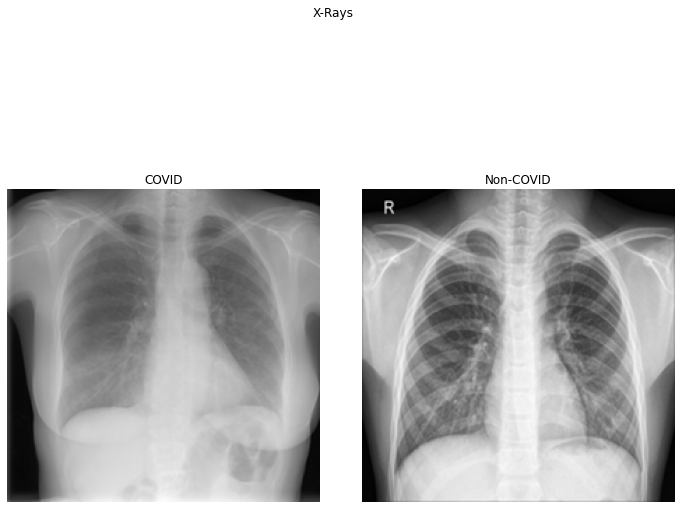

In [5]:
covid_example = resize(cv2.imread(os.path.join(covid_image_dir,os.listdir(covid_image_dir)[0])),224)
non_covid_example = resize(cv2.imread(os.path.join(non_covid_image_dir,os.listdir(non_covid_image_dir)[0])),224)

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=[10,10])
fig.tight_layout()
axs[0].imshow(covid_example)
axs[0].set_title('COVID')
axs[0].axis('off')
axs[1].imshow(non_covid_example)
axs[1].set_title('Non-COVID')
axs[1].axis('off')
fig.suptitle('X-Rays')
plt.show()

In [6]:
def flip(img):
    return cv2.flip(img,1)

def rotate(img, rotation_range=20):
    return tf.keras.preprocessing.image.random_rotation(img,rotation_range,channel_axis=2)

def shear(img, shear_range= 20):
    return tf.keras.preprocessing.image.random_shear(img, shear_range,channel_axis=2)

def zoom(img, zoom_range=0.75):
    return tf.keras.preprocessing.image.random_zoom(img, (zoom_range,zoom_range),channel_axis=2)

In [7]:
from scipy import signal
from scipy import ndimage

import copy
import warnings

def histogram_equalization(image_data):
    if type(image_data) is not np.ndarray:
        warnings.warn('Should be a numpy array')
    shape = image_data.shape
    _histogram, _bins = np.histogram(image_data.flatten(), 256, density=True)
    cdf = _histogram.cumsum()
    # Now we normalize the cdf
    cdf = 255 * cdf / cdf[-1]
    image_data = np.interp(image_data.flatten(), _bins[:-1], cdf)
    return image_data.reshape(shape)


def histogram_s_curve(image_data):
    image_data = histogram_equalization(image_data)
    shape = image_data.shape
    _histogram, _bins = np.histogram(image_data.flatten(), 256, density=True)
    cdf = 1 / (1 + np.exp((1 / 25) * (158 - _bins)))
    # print('hiu', new_curve.max())
    # cdf = new_curve.cumsum()
    # plt.plot(cdf)
    # plt.show()
    cdf = 255 * cdf / cdf[-1]
    image_data = np.interp(image_data.flatten(), _bins, cdf)
    return image_data.reshape(shape)


def find_shoulders(image_data, center=None, spine_start=None, spine_end=None, should_plot=False):
    min_height_of_area_to_check = 0
    max_height_of_area_to_check = 125
    threshold = 64
    sigma = 1
    buffer_to_ignore = 10

    if (center is None) or (spine_start is None) or (spine_end is None):
        warnings.warn('Information not provided so find_spine may be running twice')
        center, spine_start, spine_end = find_spine(image_data, False)
    _image_data = copy.deepcopy(image_data)
    _image_data[_image_data <= threshold] = 0
    _image_data[_image_data > threshold] = 255
    # Gaussian filter this
    _image_data = ndimage.gaussian_filter(_image_data, sigma=sigma)
    _image_data = np.transpose(ndimage.prewitt(np.transpose(_image_data)))
#     plt.imshow(_image_data, cmap='gray')
#     plt.show()
    _image_data = np.concatenate((_image_data[:, :int(spine_start - buffer_to_ignore)],
                                  _image_data[:, int(spine_end + buffer_to_ignore):]), axis=1)
    energies = np.sum(_image_data, axis=1)
    if should_plot:
        plt.plot(energies)
        plt.show()

    maximum_index, info = signal.find_peaks(energies[min_height_of_area_to_check:max_height_of_area_to_check],
                                            distance=max_height_of_area_to_check)
    return maximum_index[0]


def find_spine(image_data, should_plot=False):
    smoothness = 50  # pixels
    width_of_area_to_check = 300  # pixels
    interval = 1  # pixels

    start_indexes = np.arange(int((image_data.shape[1] - width_of_area_to_check) / 2),
                              int((image_data.shape[1] + width_of_area_to_check) / 2), interval)
    end_indexes = start_indexes + smoothness
    energies = start_indexes * 0
    for i in range(start_indexes.shape[0]):
        start_index = start_indexes[i]
        end_index = end_indexes[i]
        energy = np.sum(np.square(image_data[:, start_index:end_index]))
        energies[i] = energy

    if should_plot:
        plt.plot(start_indexes, energies)
        plt.show()

    maximum_index, info = signal.find_peaks(energies, width=10, rel_height=0.5, distance=len(energies))
    spine_start = start_indexes[maximum_index]
    spine_end = end_indexes[maximum_index]
    center = int((spine_start + spine_end) / 2)
    spine_start = int(center - (info['widths'] / 2))
    spine_end = int(center + (info['widths'] / 2))
    return center, spine_start, spine_end


def find_sides_of_body(image_data, shoulders_index=None, center=None, spine_start=None, spine_end=None,
                       should_plot=False):
    width_to_check_from_edge = 100
    if (center is None) or (spine_start is None) or (spine_end is None):
        warnings.warn('Information not provided so find_spine may be running twice')
        center, spine_start, spine_end = find_spine(image_data, should_plot)
    image_center = np.round(image_data.shape[0] / 2)
    if shoulders_index is None:
        warnings.warn('Information not provided so find_shoulders may be running twice')
        shoulders_index = find_shoulders(image_data, center, spine_start, spine_end, should_plot)
    _image_data = copy.deepcopy(image_data)
    _image_data = _image_data[shoulders_index:300, :]
    _image_data = histogram_s_curve(_image_data)

    energies = np.sum(_image_data, axis=0)
    energies = np.convolve(energies, [1 for _ in range(20)], mode='same')
    maximum_index, info = signal.find_peaks(energies, distance=125)
    if should_plot:
        x1 = np.arange(-1 * center, image_data.shape[1] - center)
        plt.plot(x1, energies)
        plt.show()
    try:
        return maximum_index[0], maximum_index[2]
    except IndexError:
        warnings.warn('An error occurred')
        return 0, image_data.shape[1] - 1
    
    
def my_preprocessing_function(file_in):
    data = np.mean(file_in, axis=2)
    data = histogram_equalization(data)

    try:
        center, spine_start, spine_end = find_spine(data, False)
        shoulders_index = find_shoulders(data, center, spine_start, spine_end)
        body_start, body_end = find_sides_of_body(data, shoulders_index, center, spine_start, spine_end)
#         data = data[body_start:body_end, int(shoulders_index):int(400 + shoulders_index)]
        data = data[int(shoulders_index):int(400 + shoulders_index), body_start:body_end]
        
        
#         data = np.pad(data, ((0, 400 - data.shape[0]), (0, 400 - data.shape[1])), mode='constant', constant_values=0)
    except:
        # then just scale the image
        #print('error')
        #data = cv2.resize(data, (400, 400))
        pass
    data = cv2.resize(data, (224, 224))
    out = np.repeat(data, 3).reshape((224, 224, 3))
    return out

In [8]:
import numpy as np
import copy


def subhist(image_pdf, minimum, maximum, normalize):
    """
    Compute the subhistogram between [minimum, maximum] of a given histogram image_pdf
    :param image_pdf: numpy.array
    :param minimum: int
    :param maximum: int
    :param normalize: boolean
    :return: numpy.array
    """
    hi = np.zeros(shape=image_pdf.shape)
    total = 0
    for idx in range(minimum, maximum+1):
        total += image_pdf[idx]
        hi[idx] = image_pdf[idx]
    if normalize:
        for idx in range(minimum, maximum+1):
            hi[idx] /= total
    return hi


def CDF(hist):
    """
    Compute the CDF of the input histogram
    :param hist: numpy.array()
    :return: numpy.array()
    """
    cdf = np.zeros(shape=hist.shape)
    cdf[0] = hist[0]
    for idx in range(1, len(hist)):
        cdf[idx] = cdf[idx - 1] + hist[idx]
    return cdf


def BEASF(image, gamma = 1.5):
    image = np.array(image)
    """
    Compute the Bi-Histogram Equalization with Adaptive Sigmoid Functions algorithm (BEASF)
    A python implementation of the original MATLAB code:
    https://mathworks.com/matlabcentral/fileexchange/47517-beasf-image-enhancer-for-gray-scale-images
    The algorithm is introduced by E. F. Arriaga-Garcia et al., in the research paper:
    https://ieeexplore.ieee.org/document/6808563
    :param image: numpy.ndarray
    :param gamma: float [0, 1]
    :return: numpy.ndarray
    """
    m = int(np.mean(image, dtype=np.int32))
    h = np.histogram(image, bins=256)[0] / (image.shape[0] * image.shape[1])
    h_lower = subhist(image_pdf=h, minimum=0, maximum=m, normalize=True)
    h_upper = subhist(image_pdf=h, minimum=m, maximum=255, normalize=True)

    cdf_lower = CDF(hist=h_lower)
    cdf_upper = CDF(hist=h_upper)

    # Find x | CDF(x) = 0.5
    half_low = 0
    for idx in range(0, m+2):
        if cdf_lower[idx] > 0.5:
            half_low = idx
            break
    half_up = 0
    for idx in range(m, 256):
        if cdf_upper[idx + 1] > 0.5:
            half_up = idx
            break

    # sigmoid CDF creation
    tones_low = np.arange(0, m+1, 1)
    x_low = 5.0 * (tones_low - half_low) / m  # shift & scale intensity x to place sigmoid [-2.5, 2.5]
    s_low = 1 / (1 + np.exp(-gamma * x_low))  # lower sigmoid

    tones_up = np.arange(m, 256, 1)
    x_up = 5.0 * (tones_up - half_up) / (255 - m)  # shift & scale intensity x to place sigmoid [-2.5, 2.5]
    s_up = 1 / (1 + np.exp(-gamma * x_up))  # upper sigmoid

    mapping_vector = np.zeros(shape=(256,))
    for idx in range(0, m+1):
        mapping_vector[idx] = np.int32(m * s_low[idx])

    minimum = mapping_vector[0]
    maximum = mapping_vector[m]
    for idx in range(0, m+1):
        mapping_vector[idx] = np.int32((m / (maximum - minimum)) * (mapping_vector[idx] - minimum))
    for idx in range(m+1, 256):
        mapping_vector[idx] = np.int32(m + (255 - m) * s_up[idx - m - 1])

    minimum = mapping_vector[m + 1]
    maximum = mapping_vector[255]
    for idx in range(m+1, 256):
        mapping_vector[idx] = (255 - m) * (mapping_vector[idx] - minimum) / (maximum - minimum) + m

    res = copy.deepcopy(image)
    res[:, :] = mapping_vector[image[:, :]]
    return res

In [9]:
def CLAHE(img): 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))
    gray = clahe.apply(gray)
    gray = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    '''
    img = np.array(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    R, G, B = cv2.split(img)

    output1_R = clahe.apply(R)
    output1_G = clahe.apply(G)
    output1_B = clahe.apply(B)

    equ = cv2.merge((output1_R, output1_G, output1_B))
    '''
    return gray

In [10]:
histogram_equalizer = lambda x: np.array(histogram_equalization(x),dtype='uint8')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:115: UserWarning: An error occurred


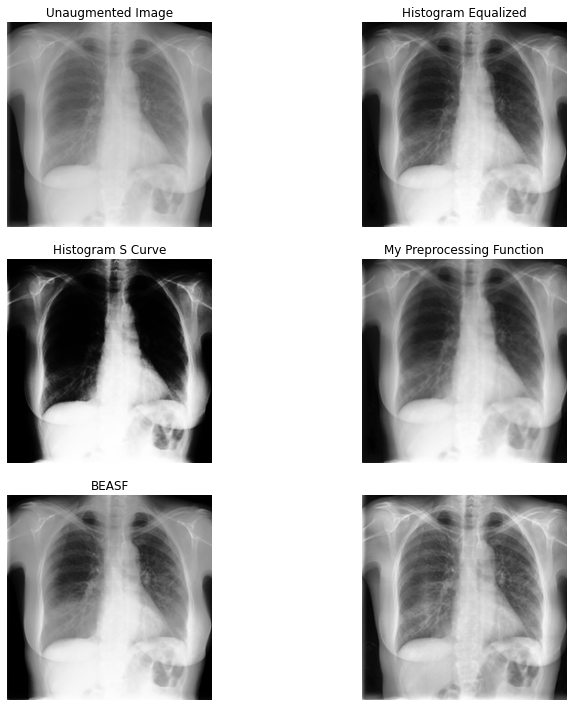

In [11]:
base_image = covid_example
histogram_equalized = histogram_equalizer(base_image)
s_curve = np.array(histogram_s_curve(base_image),dtype='uint8')
whole_preprocessing = np.array(my_preprocessing_function(base_image), dtype='uint8')
beasf = BEASF(base_image)
c = np.array(CLAHE(base_image))
#aaron's preprocessing visualized
fig, axs = plt.subplots(nrows=3,ncols=2,figsize=[10,10])
fig.tight_layout()
axs[0,0].imshow(base_image)
axs[0,0].set_title('Unaugmented Image')
axs[0,0].axis('off')

axs[0,1].imshow(histogram_equalized)
axs[0,1].set_title('Histogram Equalized')
axs[0,1].axis('off')

axs[1,0].imshow(s_curve)
axs[1,0].set_title('Histogram S Curve')
axs[1,0].axis('off')

axs[1,1].imshow(whole_preprocessing)
axs[1,1].set_title('My Preprocessing Function')
axs[1,1].axis('off')

axs[2,0].imshow(beasf)
axs[2,0].set_title('BEASF')
axs[2,0].axis('off')

axs[2,1].imshow(c)
axs[2,1].axis('off')

plt.show()

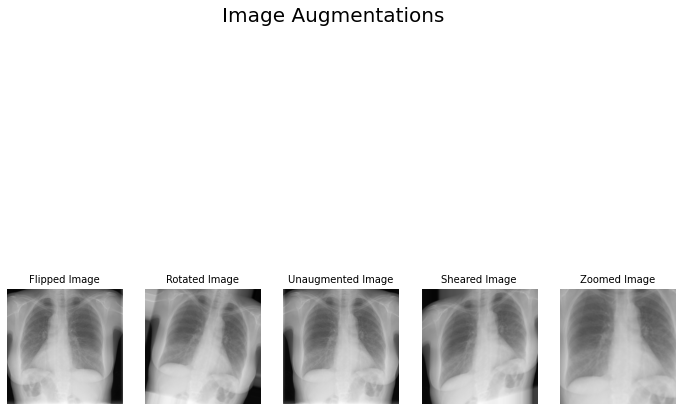

In [12]:
base_image = covid_example
flipped_image = flip(base_image)
rotated_image = rotate(base_image)
sheared_image = shear(base_image)
zoomed_image = zoom(base_image)

w , h = 10, 10
nrows, ncols = 1 , 5
figsize = [h,w]
fig, axs  = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
fig.tight_layout()

axs[0].imshow(flipped_image)
axs[0].set_title('Flipped Image', fontsize=10)
axs[0].axis('off')

axs[1].imshow(rotated_image)
axs[1].set_title('Rotated Image', fontsize=10)
axs[1].axis('off')

axs[2].imshow(base_image)
axs[2].set_title('Unaugmented Image', fontsize=10)
axs[2].axis('off')

axs[3].imshow(sheared_image)
axs[3].set_title('Sheared Image', fontsize=10)
axs[3].axis('off')

axs[4].imshow(zoomed_image)
axs[4].set_title('Zoomed Image', fontsize=10)
axs[4].axis('off')

plt.subplots_adjust(wspace=0.2,hspace=0)
fig.suptitle('Image Augmentations', fontsize=20)
plt.show()

In [13]:
labels = np.concatenate((np.repeat('COVID',len(os.listdir(covid_image_dir))),np.repeat('Normal',len(os.listdir(non_covid_image_dir)))))
image_files = np.concatenate((os.listdir(covid_image_dir),os.listdir(non_covid_image_dir)))
df = pd.DataFrame({'image_id':image_files,'class_id':labels})
df.head()

,image_id,class_id
0,COVID-1994.png,COVID
1,COVID-1825.png,COVID
2,COVID-517.png,COVID
3,COVID-532.png,COVID
4,COVID-2272.png,COVID


In [14]:
from sklearn.model_selection import train_test_split
train,validation = train_test_split(df.index,stratify=df.class_id, test_size = 0.10)
train_df = df.loc[train]
validation_df = df.loc[validation]

In [15]:
print(f'Size of training set is: {train_df.shape[0]} images')
train_df.class_id.value_counts(normalize=True)

Size of training set is: 12427 images


Normal    0.738151
COVID     0.261849
Name: class_id, dtype: float64

In [16]:
print(f'Size of validationset is: {validation_df.shape[0]} images')
validation_df.class_id.value_counts(normalize=True)

Size of validationset is: 1381 images


Normal    0.737871
COVID     0.262129
Name: class_id, dtype: float64

In [18]:
os.makedirs('/kaggle/working/train/COVID', exist_ok = True)
os.makedirs('/kaggle/working/train/Normal', exist_ok = True)
os.makedirs('/kaggle/working/validation/COVID', exist_ok = True)
os.makedirs('/kaggle/working/validation/Normal', exist_ok = True)

for i,row in tqdm(train_df.iterrows()):
    path = os.path.join(data_dir,row.class_id,row.image_id)
    img = cv2.imread(path)
    img = my_preprocessing_function(img)
    new_path = os.path.join('/kaggle/working/train', row.class_id, row.image_id)
    cv2.imwrite(new_path,img)
    #shutil.copy(path,new_path)
    
for i,row in tqdm(validation_df.iterrows()):
    path = os.path.join(data_dir,row.class_id,row.image_id)
    img = cv2.imread(path)
    img = my_preprocessing_function(img)
    new_path = os.path.join('/kaggle/working/validation', row.class_id, row.image_id)
    cv2.imwrite(new_path,img)
    #shutil.copy(path,new_path)

0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:115: UserWarning: An error occurred


0it [00:00, ?it/s]

In [19]:
import shutil

In [20]:
from keras.preprocessing.image import ImageDataGenerator
def process_data(batch_size = 32, image_dim = 224):
    train_gen = ImageDataGenerator(rescale=1/256, rotation_range = 0.05,shear_range = 0.05, zoom_range=0.05,vertical_flip=True, horizontal_flip=True)
    validation_gen = ImageDataGenerator(rescale = 1/256)
    
    train_gen = train_gen.flow_from_directory(
    directory = '/kaggle/working/train',
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True,
    target_size = (image_dim,image_dim)
    )
    
    validation_gen = validation_gen.flow_from_directory(
    directory = '/kaggle/working/validation',
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True,
    target_size = (image_dim,image_dim)
    )
    
    return train_gen, validation_gen

vgg_train_gen , vgg_validation_gen = process_data()

Found 12427 images belonging to 2 classes.
Found 1381 images belonging to 2 classes.


In [21]:
image_generator1 = ImageDataGenerator(rescale=1/256, preprocessing_function=None, horizontal_flip=False)
image_generator2 = ImageDataGenerator(rescale=1/256, preprocessing_function = None)


train_gen = image_generator1.flow_from_directory(batch_size=32,
                                                    directory=r'/kaggle/working/train',
                                                    shuffle=True,
                                                    target_size=(512, 512),
                                                    class_mode='binary')

validation_gen = image_generator2.flow_from_directory(batch_size=32,
                                                   directory=r'/kaggle/working/validation',
                                                   shuffle=True,
                                                   target_size=(512, 512),
                                                   class_mode='binary')

Found 12427 images belonging to 2 classes.
Found 1381 images belonging to 2 classes.


In [83]:
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

base_model = DenseNet121(include_top = False, weights='imagenet', input_shape=(224,224,3))

input_layer = Input(shape=(224,224,3))
x = preprocess_input_densenet(input_layer)
x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = Dense(10, activation='relu')(x)
x = Dropout(0.2)(x)
output_layer = Dense(1, activation = 'sigmoid')(x)

for layer in base_model.layers[:-6]:
    layer.trainable = False


densenet_model = Model(inputs=[input_layer], outputs=[output_layer])
densenet_model.compile(Adam(lr=.0001), loss = 'binary_crossentropy', metrics =[METRICS])
densenet_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_4 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_2 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_5 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1025

In [23]:
densenet_checkpoint_callback = ModelCheckpoint('DenseNet_model_augs.h5', monitor='val_accuracy', verbose = True, save_best_only = True, save_weights_only = False, mode= 'max')
densenet_early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=5)

with tf.device('/GPU:0'):
    densenet_fit = densenet_model.fit_generator(generator=train_gen,
                              validation_data=validation_gen,
                              steps_per_epoch= (train_gen.samples // 32),
                              validation_steps = (validation_gen.samples // 32),
                              use_multiprocessing=True,
                              workers=-1,
                              verbose = True,
                              epochs = 20,
                              callbacks = [densenet_checkpoint_callback, densenet_early_stopping_callback])

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
388/388 [==============================] - 250s 610ms/step - loss: 0.6352 - accuracy: 0.6670 - precision: 0.7427 - recall: 0.8390 - val_loss: 0.5761 - val_accuracy: 0.7391 - val_precision: 0.7391 - val_recall: 1.0000

Epoch 00001: val_accuracy improved from -inf to 0.73910, saving model to DenseNet_model_augs.h5
Epoch 2/20
388/388 [==============================] - 231s 595ms/step - loss: 0.5740 - accuracy: 0.7383 - precision: 0.7394 - recall: 0.9974 - val_loss: 0.5299 - val_accuracy: 0.7500 - val_precision: 0.7482 - val_recall: 0.9970

Epoch 00002: val_accuracy improved from 0.73910 to 0.75000, saving model to DenseNet_model_augs.h5
Epoch 3/20
388/388 [==============================] - 231s 596ms/step - loss: 0.5317 - accuracy: 0.7242 - precision: 0.7588 - recall: 0.9184 - val_loss: 0.4887 - val_accuracy: 0.8110 - val_precision: 0.8082 - val_recall: 0.9754

Epoch 00003: val_accuracy improved from 0.75000 to 0.81105, saving model to DenseNet_model_augs.h5
Epoch 4/20
388/388 

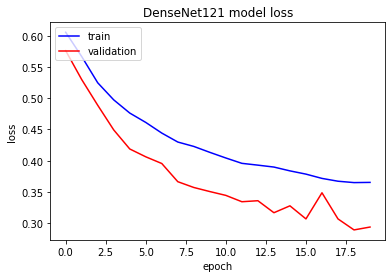

In [24]:
plt.plot(np.array(densenet_fit.history['loss']),color='blue')
plt.plot(np.array(densenet_fit.history['val_loss']),color='red')
plt.title('DenseNet121 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

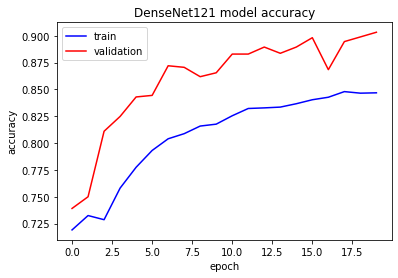

In [25]:
plt.plot(np.array(densenet_fit.history['accuracy']),color='blue')
plt.plot(np.array(densenet_fit.history['val_accuracy']),color='red')
plt.title('DenseNet121 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [26]:
with open('densenet_model_augs_history.pickle','wb') as file:
    pickle.dump(densenet_fit.history,file)

In [27]:
with open('densenet_model_augs_history.pickle', 'rb') as file:
    history = pickle.load(file)

In [74]:
print(history)

{'loss': [0.605546772480011, 0.5667008757591248, 0.5246936678886414, 0.4973202347755432, 0.47622355818748474, 0.46121716499328613, 0.44417497515678406, 0.4298276901245117, 0.42279088497161865, 0.4133152365684509, 0.40429195761680603, 0.39573049545288086, 0.39284422993659973, 0.38978683948516846, 0.38367974758148193, 0.3784734308719635, 0.3716280460357666, 0.3671131730079651, 0.36491456627845764, 0.3652372360229492], 'accuracy': [0.7190802693367004, 0.7324727773666382, 0.728600263595581, 0.7580475807189941, 0.7774909138679504, 0.7931423783302307, 0.8040338754653931, 0.808793842792511, 0.8158935308456421, 0.8176684379577637, 0.8254941701889038, 0.8322710990905762, 0.8328357934951782, 0.833561897277832, 0.8367083668708801, 0.8404195308685303, 0.8427591919898987, 0.8480032086372375, 0.8465510010719299, 0.8468737602233887], 'precision': [0.7390937209129333, 0.7404353618621826, 0.7631219625473022, 0.7886438369750977, 0.8057044148445129, 0.8188419938087463, 0.8281418085098267, 0.8352441191673

In [90]:
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
# from tensorflow.keras.models import load_model
# import numpy as np

# predict_image_path = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-10001.png'
# predict_image = image.load_img(predict_image_path, target_size=(224, 224))
# predict_x = image.img_to_array(predict_image)
# predict_x = predict_x/255
# predict_x = np.array(predict_x)
# predict_x = np.expand_dims(predict_x, axis=0)
# predict_x = preprocess_input(predict_x)

# prediction_model = load_model("./DenseNet_model_augs.h5")
# prediction = prediction_model.predict(predict_x)
# best_pred = np.argmax(prediction)

# print(best_pred)

# final_preds = densenet_model.predict(predict_x)

# print('Predicted: ', decode_predictions(final_preds, top=3)[0])

0


In [ ]:
shutil.rmtree('/kaggle/working/validation')
shutil.rmtree('/kaggle/working/train')